# A Wasserstein GAN for Joint Learning of Inpainting and its Spatial Optimisation

<b>Author and Supervisor: Pascal Peter</b>

<b>Rahul Nittala, 22.08.2022</b>


## Abstract

Spatial optimisation deals with identifying important pixels in an image using which a reconstruction would be possible using an associated inpainting operation. Existing methods that try to solve this problem are either slow, restricted to certain inpainting operators, use continuous masks, or don't jointly train the mask generation and inpainting operations. The method proposed in the paper [A Wasserstein GAN for Joint Learning of Inpainting and its Spatial Optimisation](https://arxiv.org/pdf/2202.05623.pdf) [[P22]](#Bibliography) overcomes all of these issues. It facilitates the use of binary masks during training and jointly trains its three constituent Wasserstein GAN-based networks namely the mask generator, generator and discriminator. Experiments are conducted as part of this notebook to not only evaluate the method quantitatively but also to test its relevance to fine-grained distributions and out-of-distribution samples. While its performance on a different dataset reinforces the numerical results shared in the paper, the image reconstructions cast doubts on the universal applicability of the models learned.

## 1. Introduction

**Image inpainting** is the task of reconstructing a full image from a partially known image. An "*inpainting operation*" is performed on the partially known image, called a "*masked image*", to get the "*inpainted image*". An extension of image inpainting is the **Spatial Optimisation Problem(SOP)** as shown in *Figure 1*. Given a complete image, SOP deals with the selection of a fraction of its pixels such that we get a good reconstructed image using an associated inpainting operation. The selected fraction of pixels form the "*Image mask*". Though both the image inpainting and the SOP tasks share the inpainting operation in their pipelines, their goals are not necessarily the same. The SOP wants the **inpainted image to be as close to the original image** as possible. Whereas, in problems like logo/watermark removal, the goal of image inpainting is to construct a **natural-looking image without unwanted parts of the original image**.

<img src="./Test_images/IIvsSOP.png" width="500" />

<p style="text-align:center"> <b>Figure 1</b>: <i>Image inpainting (red box) and Spatial Optimisation Problem (blue box).</i> </p>

SOP finds applications in image compression and adaptive sampling tasks. 
1. **Image compression**: The *mask generation* and the *inpainting operation* would act as the encoder and decoder respectively and the *masked image* would act as the compressed spatial representation.
<img src="./Test_images/Figures/2.png" width="500" />
<p style="text-align:center"> <b>Figure 2</b>: <i>Spatial Optimisation Problem in Image Compression.</i> </p>
2. **Adaptive sampling**: Only sample at pixel locations directed by the image mask and reconstruct from sampled data. The Dai et al. paper [[DCPC+20]](#Bibliography) shows how doing this reduces the time it takes to scan a high resolution X-Ray fluorescence image.
<img src="./Test_images/Figures/3.png" width="500" />
<center> <b>Figure 3</b>: <i>Spatial Optimisation Problem in Adaptive sampling. Image: Dai et al.$^1$</i> </center>

$^1$ reference: [[DCPC+20]](#Bibliography)

### 1.1 Related Work

The mask generation task in SOP is a non-trivial combinatorial problem. We can formulate it as given $T$ total pixels select $k$ of them. A naive brute-force approach is intractable as a simple real-world scenario of selecting 5% of pixels from a 256$\times $256 image generates 1.72e+5648 possibilities.

Mainberger et al.[[MHWT+12]](#Bibliography) put forward Probabilistic Sparsification together with NonLocal Pixel Exchange(PS+NLPE) as the mask generation algorithm. It uses the widely known homogeneous diffusion as the inpainter. The pipeline of PS is shown in *Figure 4*. It is an iterative process that operates on the principle that the pixels responsible for **large local reconstruction errors** are important. In each iteration, the known data affects the inpainter's reconstruction quality and this reconstruction quality in the form of local errors in turn affects which pixels act as known data for the upcoming iteration. This points to a **strong coupling** between the mask selection and inapinting operations. NLPE is a post-processing step. It exchanges pixels between known and unknown data if doing so improves the reconstruction error.

<img src="./Test_images/Figures/PS-1.png" width="800" />
<center> <b>Figure 4</b>: <i>Probabilistic Sparsification(PS) pipeline proposed by Mainberger et al.$^2$</i> </center>

PS+NLPE gives great results across images of any resolution and any image sampling density. But since PS, NLPE and homogeneous diffusion are all iterative methods, they are **slow in generating the mask** for each image.

Alt et al. [[APW+22]](#Bibliography) replace every iterative aspect with faster neural networks that only take a single forward pass to generate the outputs. They jointly train a mask network along with a surrogate inpainting network which is **restricted to mimic homogeneous diffusion**. Continuous masks in the range $[0,1)$ were used during training and a weighted coin flip discretized the masks during testing.

Dai et al.[[DCPC+20]](#Bibliography) proposed a more general neural network-based method called NetM+NetE. It offers flexibility in terms of the inpainting operation learned. The pipeline is shown in *Figure 5*. Similar to the previous approach, continuous masks in the range $[0,1)$ were used during training. And using a mean adjustment layer followed by a Bernoulli coin toss resulted in discrete 0/1 masks during test time. This dicrepancy is due to the non-differentiability of binarization operation. A more detailed discussion on this is given in [[Section 2.3]](#2.3.-Binarization). The **training process is disjoint** with NetE trained first on randomly generated masks. Then NetM is trained with NetE frozen. Though joint training did not yield good results for them, it was due to the lack of strict binary masks while training.

<img src="./Test_images/Figures/mask_design_pipeline.png" width="800" />
<center> <b>Figure 5</b>: <i>NetM+NetE pipeline proposed by Dai et al.$^3$</i> </center>

Recently, state-of-the-art results were achieved by the Wasserstein Generative Adversarial Imputation Network(WGAIN)[[VHF21]](#Bibliography) in the image inpainting task. Wasserstein GANs were trained under scenarios varying from a large chunk of continuously missing data on one extreme to randomly missing pixels on the other extreme. Vašata et al. have shown that the resultant models generated natural-looking images even when 95% of the data is missing.

$^2$ reference: [[MHWT+12]](#Bibliography)<br>
$^3$ reference: [[DCPC+20]](#Bibliography)

### 1.2 Characteristics of an ideal Approach

Having looked at the related work it can be summarised that an ideal method must possess the following qualities:
- Be fast and non-iterative,
- Allow inpainting operation to be developed independently(no restrictions),
- Jointly train the mask generation and inpainting operations,
- Enforce strict Binarization during training and testing.

The algorithm that [[P22]](#Bibliography) postulate satisfies all the above requirements. It uses a deep WGAN-based architecture that is fast. Since the loss functions used do not emulate any specific operators, the inpainter can be tuned to perform well for a target image distribution. Gradient approximation techniques used within the signal quantization domain were used to make the binarization operation differentiable within training. This makes it possible for all networks to be jointly trained while maintaining consistency between testing and training conditions.

### 1.3 Organisation of the Write-Up

In [Section 2](#2.-Methodology) we look at the joint training mechanism proposed for solving the SOP task and discuss the architectures of the models used in the pipeline and their associated losses. We implement the methodology in [Section 3](#3.-Practice:-Implementation-and-Experiments) and train two different model scenarios. [Section 4](#4.-TESTING-THE-PERFROMANCE-OF-THE-TRAINED-MODELS) includes testing of learned models and discussion of their qualitative and quantitative performance. Finally, we summarise the report in [Conclusion section](#Conclusions) 

## 2. Methodology

### 2.1. Building Blocks and Pipeline

Since Wasserstein GANs are very successful in the image inpainting task, the author builds his methodology around it. The pipeline proposed is shown in *Figure 6*. Consider an image $f \in \mathbb{R}^{m \times n\times k}$ with the resolution $m\times n$ and $k$ channels. Firstly, a *Mask Generator* ($m:\mathbb{R}^{m \times n\times k}\rightarrow \{0,1\}^{m\times n}$) maps the image $f$ onto a corresponding mask $b \in \{0,1\}^{m\times n}$ where a value $1$ means the pixel is selected/known and $0$ means otherwise.

$$b = m(f)$$

The *Masked Image* would then be represented by $f\odot b$, where $\odot$ is the element-wise multiplication operation. The masks returned by the mask generator $m$ should be binary during training as well as during testing.

<img src="./Test_images/Figures/new_pipeline.png" width="800" />
<center> <b>Figure 6</b>: <i>Mask Generation + Wasserstein GAN based inpainnting(MG+WGAN) pipeline.</i> </center>

Inspired from Vašata et al.[[VHF21]](#Bibliography), the inpainting network uses Wasserstein GANs to create good-quality reconstructions that look very natural and similar to the input distribution. It consists of two networks namely, the *Generator* $g$ and the *Discriminator* $d$. In a typical GAN, $g$ and $d$ play an adversarial game. While the discriminator tries to learn whether a given sample is real or synthesized, the generator tries to fool the discriminator into believing that the synthesized image is real. But GANs suffer from problems like instability, modal collapse, or failure to converge. One remedy is to use Wasserstein GANs[[ACB17]](#Bibliography) that enforce a Lipschitz continuity restriction on the discriminator. In the pipeline, the generator takes the masked image $b\odot f$ and the mask $b$ itself and gives the reconstruction $g(f\odot b, b)$. The inpainted image $u$ would then be given as:

$$u(f\odot b, b) = \big[(I-b)\odot g(f\odot b, b)\big] + \big[f\odot b\big]$$

The above equation can be summarised as, at locations where data is known($b$), use the pixel value from the original image $f$. And at locations where the data is unknown($I-b$), use the pixel value from the generated image $g(f\odot b, b)$. The discriminator $d$ takes the original image $f$ and the inpainted image $u(f\odot b, b)$ along with the mask $b$ itself and gives out scores representing how real or fake they are. The corresponding representations of the scores are $d(f, b)$ and $d(u(f\odot b, b), b)$ respectively. The paper follows the notation that smaller scores correspond to samples that are close to input distribution. It is the responsibility of the WGAN network to ensure a good quality image reconstruction that looks as close to the natural distribution of the original image as possible.

### 2.2. Network Architectures

<img src="./Test_images/Figures/fullNetwork1.png" width="800" />
<center> <b>Figure 7</b>: <i>Full joint training architecture of Mask Generation + Wasserstein GAN based inpainnting(MG+WGAN) pipeline.</i> </center>

The complete architecture is shown in *Figure 7*. The proposed generator network $g$ has an hour-glass-shaped encoder-decoder architecture. The encoder consists of a series of convolutional blocks with downsampling layers at the end of each of them. Similarly, the decoder consists of a series of corresponding transposed convolutional blocks ending with upsampling layers. Skip connections exist between encoder and decoder blocks of corresponding scales. These skip connections facilitate the transfer of relevant information across layers. Each convolutional block also uses parallel conv layers of different dilation rates. As the dilation rate affects the corresponding receptive field, local and global features of relevant scales can be sufficiently captured. To ensure that we get an image with pixel values in the range $[0,1]$, the architecture uses a convolutional layer with hard sigmoid activation as the final block.

The discriminator network $d$ has a funnel-shaped architecture. It consists of a series of funnel blocks that gradually downsample the feature space. The resultant features are then flattened and fed to a fully connected layer with a single unit corresponding to the discriminator score.

The mask generator network $m$ has the same architecture as the generator network. The only difference is the Binarization layer used at the end. It makes sure that only binary masks are returned. Let us now have a closer look at it.

<div class="alert alert-block alert-info">
Further details like number of filters, filter sizes, dilation rates etc., are discussed in Section 3
</div>

### 2.3. Binarization

Thresholding function(shown in *Figure 8*) can be used to convert continuous mask values in the range $[0,1]$ into discrete binary masks $b\in \{0,1\}$. This is otherwise called a rounding function denoted by $[.]$. The equation for the thresholding function is as follows:

$$ f(x)= [x] = \lfloor x+0.5\rfloor = \left\{
\begin{array}{ll}
      0 & x\ge 0.5 \\
      1 & x<0.5 \\
\end{array} 
\right.\\
\text{where } \lfloor . \rfloor\text{ is the floor operation}
$$

<img src="./Test_images/Figures/Threshold_func.png" width="200" />
<center> <b>Figure 8</b>: <i>Thresholding function plot.</i> </center>
But it is not differentiable at $x=0.5$ where it is undefined. Since the backpropagation algorithm requires all of its operations to be differentiable, the thresholding function cannot be used directly for the binarization of masks.

Quantization is a signal compression approach. Its objective is to encode a signal using the least number of bits possible such that the reconstruction error is sufficiently small. The loss function is as follows:

$$
\begin{equation}
\mathcal{L} = \mathbb{E}\{\text{Number of bits} + \beta \times \text{Reconstruction error}\}\\
\mathcal{L} = \mathbb{E}_{y}\{-\log_{2}(P([y])) + \beta \times \text{Reconstruction error}\}\\
\text{where } [.]\text{ is the rounding operation}
\end{equation}
$$

Two potential solutions were proposed to solve the differentiability issue. [[BLS16]](#Bibliography) proposed replacing rounding function with an equivalent continuous function. And [[TOHV+15]](#Bibliography) proposed using pseudo gradients. Theis et al. [[TSCH17]](#Bibliography) compared multiple approaches that attempt to make rounding function differentiable. They concluded that approximating $[x]\approx x$ gave good results. The gradient would then be:

$$
\begin{equation}
\frac{\partial [x]}{\partial x} \approx \frac{\partial x}{\partial x} = 1
\end{equation}
$$

Since the gradient is $1$ everywhere, it needs no further processing. Whatever gradients flow into the Binarization layer can be propagated back as is.

### 2.4 Losses and Joint Training

Generally, generator networks of GANs take a randomly sampled seed along with other inputs and map them to a target distribution. Following the same pattern we provide random seeds $r$ sampled from a source distribution $P_s$ as additional inputs to both the mask generator $m$ and generator $g$. All the equations shown below are written to accommodate this sampled seed.

**Discriminator Loss:** Considering that lower discriminator score means closeness to the real input distribution, the discriminator network $d$ should minimize the score $d(f,b)$ for the real image $f$ and maximize the score $d(u(f\odot b,b,r),b)$ for the inpainted image $u(f\odot b,b,r)$. The loss would look like:

$$
\begin{align}
\mathcal{L}_{d} &= \mathbb{E}_{f\sim \mathbb{P}_t}\Big[d(f,b) - \mathbb{E}_{r\sim \mathbb{P}_s}\big[d\big(u(f\odot b,b,r),b\big)\big]\Big]\\
\text{where    } \mathbb{E}&, \text{ average across batch}\\
\mathbb{P}_t&, \text{ target distribution of the original images }f\\
\mathbb{P}_s&, \text{ source distribution of the random seed }r\\
\end{align}
$$

In addition, author proposes that the discriminator's weights should be normalized such that their L2-norm is 1 as a way to approximate Lipschitz property. Gradient penalty[[GAAD+17]](#Bibliography) and Spectral normalization[[MKKY18]](#Bibliography) are other methods that enforce Lipschitz property.

**Generator Loss:** The generator network $g$ should try to minimize the discriminator score $d(u(f\odot b,b,r),b)$ of the inpainted image $u(f\odot b,b,r)$. The inpainted image should also be as close to the original image as possible. Mean absolute error(MAE) is used as the image reconstruction loss.

$$
\begin{align}
\mathcal{L}_g &= \alpha \text{.Generator Loss} + \text{.Image Reconstruction Loss}\\
\mathcal{L}_g &= \mathbb{E}_{f\sim \mathbb{P}_t, r\sim \mathbb{P}_s}\Big[\alpha .d\big(u(f\odot b,b,r),b\big) + \big\Vert f-u(f\odot b,b,r)\big\Vert_1 \Big]\\
\text{where    } \alpha &, \text{ relative weight of generator loss.}
\end{align}
$$

**Mask generator Loss:** Since the mask $b$ generated by $m$ has a direct impact on the inpainted image $u$, image reconstruction loss is applicable to $m$. In addition, we need the percent of pixels selected by the mask $b$ to be close to a target mask density $D$. The mask density loss calculated as MSE error between the selected and target density would encourage the closeness.

$$
\begin{align}
\mathcal{L}_m &= \beta \text{.Image Reconstruction Loss} + \text{.Mask Density Loss}\\
\mathcal{L}_m &= \mathbb{E}_{f\sim \mathbb{P}_t, r\sim \mathbb{P}_s}\Big[\beta .\big\Vert f-u(f\odot b,b,r)\big\Vert_1 + \Big\Vert \frac{\vert b\vert_1}{N} - D\Big\Vert_2 \Big]\\
\text{where    } b&= m(r,f) \text{ Mask generated by }m\text{ for the original image }f\\
N&, \text{ total number of pixels in image}\\
D&, \text{ target mask density}\\
\beta &, \text{ relative weight of MAE loss.}
\end{align}
$$

**All three networks are jointly updated at every epoch.**

## 3. Practice: Implementation and Experiments

### 3.1. Import relevant libraries

Please have a look at the **requirements.txt** file for the prerequisite libraries and their versions.<br>

In [1]:
#!pip install -r requirements.txt

import torch
import torch.autograd
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToPILImage

from tensorboardX import SummaryWriter

from Module.Normalization import  SpectralNorm

import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
import os
from pathlib import Path
from typing import TypeVar, Union

#Static objects created for Type hinting
Torch_Tensor = TypeVar('Torch_Tensor', bound=torch.Tensor)
Summary_Writer_Tensorboard = TypeVar('Summary_Writer_Tensorboard', bound=SummaryWriter)

#Device to run tensor operations on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 3.2. Initialize Hyperparameters for Training

The following are the hyperparameters and their values that were used across the training scenarios. Please make changes to the default values if necessary before starting the training.

In [2]:
class Configuration:
    def __init__(self):
        
        # Training setting
        self.total_epoch=200                          # Total number of training epochs
        self.num_workers=2                            # Number of dataloader workers
        self.generator_learning_rate=5e-5             # Learning rate for both Generator networks
        self.discriminator_learning_rate=5e-5         # Learning rate for the Discriminator network
        self.batch_size=16                            # Batch size for each epoch
        self.discriminator_update_iterations=1        # Number of iterations for the Discriminator update step
        self.alpha = 0.005                            # alpha value in equation L_g
        self.beta = 1                                 # beta value in equation L_g
        self.gamma = 100                              # gamma value in equation L_g
        self.wanted_image_density = 0.05              # Target density of pixels to be selected for each mask.
        
        # Start training from an already trained model?
        self.pretrained_model = None                  # Step number of the pretrained models to resume training from there

        # Misc
        self.parallel=True                            # Use multiple GPUs if they are available 
        self.gpus=["0"]                               # List of GPUs to use
        self.use_tensorboard_for_logs=True            # Create tensorboardX logs

        # Paths
        self.current_dir = os.getcwd()
        # Path of the root folder of dataset
        self.data_dir = os.path.join(self.current_dir, Path('./CelebA_HQ_facial_identity_dataset'))     
        # Path of the folder to save tensorboard logs
        self.log_path = os.path.join(self.current_dir, Path("./output_dlvc/logs"))                      
        # Path of the folder to save trained models
        self.model_save_path = os.path.join(self.current_dir, Path("./outputs_dlvc/modelsZ"))           

            # epoch size
        self.log_epoch=1                              # Create a tensorboardX log
        self.model_save_epoch=1                       # Save new models for each network being trained
        self.version = ""                             # Version of the run

In [3]:
config = Configuration()

### 3.3 Prepare Dataset

We use **CELEBA HQ Facial Identity dataset** in our experiments.
<table>
    <tr>
        <td> <img src="./Test_images/Celebrity1.jpg" width="200" /> </td>
        <td> <img src="./Test_images/Celebrity2.jpg" width="200" /> </td>
        <td> <img src="./Test_images/Celebrity3.jpg" width="200" /> </td>
    </tr>
</table>


Please download the dataset from the following link: [CELEBA_HQ_facial_identity_dataset](https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1) and unzip it into the current directory. In case the dataset is downloaded to another directory, please don't forget to provide the path of the root directory to the *data_dir* parameter of Configuration object.

On an linux machine run the following lines to download the dataset
- !wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 -O CelebA_HQ_facial_identity_dataset.zip
- !unzip CelebA_HQ_facial_identity_dataset.zip -d ./CelebA_HQ_facial_identity_dataset

Each image of the dataset has the resolution 1024x1024. We preprocess the data as follows:
1. Resize them to 128x128 resolution
2. Mirror the images horizontally as a data augmentation method.

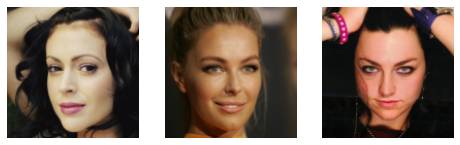

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(os.path.join(config.data_dir, 'train'),
                                     transforms_train)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=config.batch_size,
                                               shuffle=True,
                                               num_workers=config.num_workers)

# Sample random ids of images to show
random_ids = np.random.randint(0, high=len(train_dataset),size=3)
convert_to_pil_image = ToPILImage()
fig = plt.figure(figsize=(8, 8))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.axis('off')
    plt.imshow(convert_to_pil_image(train_dataset[random_ids[i]][0]))
plt.show()

### 3.4 CREATE THE ARCHITECTURES FOR MASK GENERATOR AND INPAINTING GENERATOR

For the Mask Generator network(named MaskGeneratorNet) $m$ we followed the following architecture:
<img src="./Test_images/Figures/MaskGeneratorNetwork.png" width="800" />
<center> <b>Figure 10</b>: <i>Architecture of Mask generator network 'm'.</i> </center>

* The **Binarization layer** works as follows:<br> In *forward propagation*, rounds each element to the nearest integer.<br>In *backward propagation*, sends back the gradients as is.

For the Generator network(named InpaintingNet) $g$ we followed the following architecture:
<img src="./Test_images/Figures/InpaintingNetwork.png" width="800" />
<center> <b>Figure 11</b>: <i>Architecture of Generator network 'g'(above). Structure of a Convolution block(below).<br>Each Conv layer uses 5x5 filters followed by ELU activation. The last two TConv layers use 3x3 filters</i> </center>


* Both the Mask Generator(*MaskGeneratorNet*) and the Inpainting Generator(*InpaintingNet*) follow the same architectuer as prescribed in the paper except the first Conv Block and the last Transposed Conv block. Both of them have 64 total channels rather than 128.

**NOTE:** Both these networks are saved in the **Generator.py** file within the **Module** folder.

In [5]:
class Binarization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output


class MaskGeneratorNet(nn.Module):
    def __init__(self,
                 in_channels=6 # 3 channels for the image and 3 channels for the random seed
                ):
        super().__init__()
        ###### C-Block Stacking ##########
        # C Block - 1
        self.l11 = nn.Conv2d(in_channels, 32, 5, padding='same')
        self.l12 = nn.Conv2d(in_channels, 16, 5, padding='same', dilation=2)
        self.l13 = nn.Conv2d(in_channels, 16, 5, padding='same', dilation=5)
        self.d1 = nn.MaxPool2d(2)
        # C Block - 2
        self.l21 = nn.Conv2d(64, 64, 5, padding='same')
        self.l22 = nn.Conv2d(64, 32, 5, padding='same', dilation=2)
        self.l23 = nn.Conv2d(64, 32, 5, padding='same', dilation=5)
        self.d2 = nn.MaxPool2d(2)
        # C Block - 3
        self.l31 = nn.Conv2d(128, 128, 5, padding='same')
        self.l32 = nn.Conv2d(128, 64, 5, padding='same', dilation=2)
        self.l33 = nn.Conv2d(128, 64, 5, padding='same', dilation=5)
        self.d3 = nn.MaxPool2d(2)
        
        # C Block - 4 or BottleNeck layer
        self.l41 = nn.Conv2d(256, 256, 5, padding='same')
        self.l42 = nn.Conv2d(256, 128, 5, padding='same', dilation=2)
        self.l43 = nn.Conv2d(256, 128, 5, padding='same', dilation=5)
        self.u1 = nn.Upsample(scale_factor=2)
        
        ###### TC-Block Stacking ##########
        # TC Block - 1
        self.tl11 = nn.ConvTranspose2d(256+512, 128, 5, padding=2)
        self.tl12 = nn.ConvTranspose2d(256+512, 64, 5, dilation=2, padding=4)
        self.tl13 = nn.ConvTranspose2d(256+512, 64, 5, dilation=5, padding=10)
        self.u2 = nn.Upsample(scale_factor=2)
        # TC Block - 2
        self.tl21 = nn.ConvTranspose2d(128+256, 64, 5, padding=2)
        self.tl22 = nn.ConvTranspose2d(128+256, 32, 5, padding=4, dilation=2)
        self.tl23 = nn.ConvTranspose2d(128+256, 32, 5, padding=10, dilation=5)
        self.u3 = nn.Upsample(scale_factor=2)
        # TC Block - 3
        self.tl31 = nn.ConvTranspose2d(64+128, 32, 5, padding=2)
        self.tl32 = nn.ConvTranspose2d(64+128, 16, 5, padding=4, dilation=2)
        self.tl33 = nn.ConvTranspose2d(64+128, 16, 5, padding=10, dilation=5)
        
        ###### TConv Layer Stacking ##########
        self.conv1 = nn.ConvTranspose2d(64+in_channels,8, 3, padding=1)
        self.conv2 = nn.ConvTranspose2d(8, 1, 3, padding=1)
        ###### Binarization ##################
        self.mask = Binarization.apply

    def forward(self, x):
        # C Block - 1
        temp1 = F.elu(self.l11(x))
        temp2 = F.elu(self.l12(x))
        temp3 = F.elu(self.l13(x))
        x1o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.d1(x1o)
        
        # C Block - 2
        temp1 = F.elu(self.l21(out))
        temp2 = F.elu(self.l22(out))
        temp3 = F.elu(self.l23(out))
        x2o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.d2(x2o)
        
        # C Block - 3
        temp1 = F.elu(self.l31(out))
        temp2 = F.elu(self.l32(out))
        temp3 = F.elu(self.l33(out))
        x3o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.d3(x3o)

        # C Block - 4
        temp1 = F.elu(self.l41(out))
        temp2 = F.elu(self.l42(out))
        temp3 = F.elu(self.l43(out))
        x4o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.u1(x4o) 
        
        # TC Block - 1
        out = torch.cat([out, x3o], dim=1)
        temp1 = F.elu(self.tl11(out))
        temp2 = F.elu(self.tl12(out))
        temp3 = F.elu(self.tl13(out))
        out = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.u2(out)
        
        # TC Block - 2
        out = torch.cat([out, x2o], dim=1)
        temp1 = F.elu(self.tl21(out))
        temp2 = F.elu(self.tl22(out))
        temp3 = F.elu(self.tl23(out))
        out = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.u3(out)
        
        # TC Block - 3
        out = torch.cat([out, x1o], dim=1)
        temp1 = F.elu(self.tl31(out))
        temp2 = F.elu(self.tl32(out))
        temp3 = F.elu(self.tl33(out))
        out = torch.cat([temp1, temp2, temp3, x], dim=1)
        
        ###### TConv Layer Stacking ##########
        out = F.elu(self.conv1(out))
        out = F.hardsigmoid(self.conv2(out))
        out = self.mask(out)
        return out

class InpaintingNet(nn.Module):
    def __init__(self,
                 in_channels=7 # 3 channels for the image + 1 channel for image mask + 3 channels for random seed
                ):
        super().__init__()
        ###### C-Block Stacking ##########
        # C Block - 1
        self.l11 = nn.Conv2d(in_channels, 32, 5, padding='same')
        self.l12 = nn.Conv2d(in_channels, 16, 5, padding='same', dilation=2)
        self.l13 = nn.Conv2d(in_channels, 16, 5, padding='same', dilation=5)
        self.d1 = nn.MaxPool2d(2)
        # C Block - 2
        self.l21 = nn.Conv2d(64, 64, 5, padding='same')
        self.l22 = nn.Conv2d(64, 32, 5, padding='same', dilation=2)
        self.l23 = nn.Conv2d(64, 32, 5, padding='same', dilation=5)
        self.d2 = nn.MaxPool2d(2)
        # C Block - 3
        self.l31 = nn.Conv2d(128, 128, 5, padding='same')
        self.l32 = nn.Conv2d(128, 64, 5, padding='same', dilation=2)
        self.l33 = nn.Conv2d(128, 64, 5, padding='same', dilation=5)
        self.d3 = nn.MaxPool2d(2)
        
        # C Block - 4 or Bottleneck layer
        self.l41 = nn.Conv2d(256, 256, 5, padding='same')
        self.l42 = nn.Conv2d(256, 128, 5, padding='same', dilation=2)
        self.l43 = nn.Conv2d(256, 128, 5, padding='same', dilation=5)
        self.u1 = nn.Upsample(scale_factor=2)
        
        # TC Block - 1
        self.tl11 = nn.ConvTranspose2d(256+512, 128, 5, padding=2)
        self.tl12 = nn.ConvTranspose2d(256+512, 64, 5, dilation=2, padding=4)
        self.tl13 = nn.ConvTranspose2d(256+512, 64, 5, dilation=5, padding=10)
        self.u2 = nn.Upsample(scale_factor=2)
        # TC Block - 2
        self.tl21 = nn.ConvTranspose2d(128+256, 64, 5, padding=2)
        self.tl22 = nn.ConvTranspose2d(128+256, 32, 5, padding=4, dilation=2)
        self.tl23 = nn.ConvTranspose2d(128+256, 32, 5, padding=10, dilation=5)
        self.u3 = nn.Upsample(scale_factor=2)
        # TC Block - 3
        self.tl31 = nn.ConvTranspose2d(64+128, 32, 5, padding=2)
        self.tl32 = nn.ConvTranspose2d(64+128, 16, 5, padding=4, dilation=2)
        self.tl33 = nn.ConvTranspose2d(64+128, 16, 5, padding=10, dilation=5)
        ###### TConv Layer Stacking ##########
        self.conv1 = nn.ConvTranspose2d(64+in_channels,8, 3, padding=1)
        self.conv2 = nn.ConvTranspose2d(8, 3, 3, padding=1)

    def forward(self, x):
        # C Block - 1
        temp1 = F.elu(self.l11(x))
        temp2 = F.elu(self.l12(x))
        temp3 = F.elu(self.l13(x))
        x1o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.d1(x1o)
        
        # C Block - 2
        temp1 = F.elu(self.l21(out))
        temp2 = F.elu(self.l22(out))
        temp3 = F.elu(self.l23(out))
        x2o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.d2(x2o)
        
        # C Block - 3
        temp1 = F.elu(self.l31(out))
        temp2 = F.elu(self.l32(out))
        temp3 = F.elu(self.l33(out))
        x3o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.d3(x3o)

        # C Block - 4
        temp1 = F.elu(self.l41(out))
        temp2 = F.elu(self.l42(out))
        temp3 = F.elu(self.l43(out))
        x4o = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.u1(x4o) 
        
        # TC Block - 1
        out = torch.cat([out, x3o], dim=1)
        temp1 = F.elu(self.tl11(out))
        temp2 = F.elu(self.tl12(out))
        temp3 = F.elu(self.tl13(out))
        out = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.u2(out)
        
        # TC Block - 2
        out = torch.cat([out, x2o], dim=1)
        temp1 = F.elu(self.tl21(out))
        temp2 = F.elu(self.tl22(out))
        temp3 = F.elu(self.tl23(out))
        out = torch.cat([temp1, temp2, temp3], dim=1)
        out = self.u3(out)
        
        # TC Block - 3
        out = torch.cat([out, x1o], dim=1)
        temp1 = F.elu(self.tl31(out))
        temp2 = F.elu(self.tl32(out))
        temp3 = F.elu(self.tl33(out))
        out = torch.cat([temp1, temp2, temp3, x], dim=1)
        
        ###### TConv Layer Stacking ##########
        out = F.elu(self.conv1(out))
        out = F.hardsigmoid(self.conv2(out))
        return out

### 3.5. CREATE THE ARCHITECTURE FOR DISCRIMINATOR

WGAN network was prescribed in the paper for stabilising the GAN training. There are multiple ways of doing this. In this implementation **Spectral Normalization** was used as the way to enfore the Lipschitz continuity.

**THE CODE FOR THE SPECTRAL NORM IS BORROWED FROM** [DVD-GAN repository by Harrypotterrrr](https://github.com/Harrypotterrrr/DVD-GAN).<br>

**Architecture details:** I used a funnel network with 4 conv blocks. Each block contains a conv layer, whose weights are normalized using spectral norm, followed by a Leaky ReLU activation and a downsampling with factor 2. We used 64,128,256,512 channels respectively for each conv block. We then flatten the embedding and used a fully connected layer to get the discriminator score. The architecture is shown as follows:

<img src="./Test_images/Figures/DiscriminatorNetwork.png" width="500" />
<center> <b>Figure 12</b>: <i>Architecture of Discriminator network 'd'</i> </center>


**NOTE:** The network is saved in the **Discriminators.py** file within the **Module** folder.

In [6]:
class DiscriminatorNet(nn.Module):
    def __init__(self,
                 in_channels=4 # 3 channels for the inpainted image + 1 channel for the image mask
                ):
        super().__init__()
        self.pre_conv = nn.Sequential(SpectralNorm(nn.Conv2d(in_channels,64,3, padding='same')),
                                      nn.LeakyReLU(),
                                      nn.MaxPool2d(2),
                                       SpectralNorm(nn.Conv2d(64,128,3, padding='same')), 
                                       nn.LeakyReLU(),
                                      nn.MaxPool2d(2),
                                      SpectralNorm(nn.Conv2d(128,256,3, padding='same')),
                                       nn.LeakyReLU(),
                                      nn.MaxPool2d(2),
                                      SpectralNorm(nn.Conv2d(256,512,3, padding='same')),
                                       nn.LeakyReLU(),
                                      nn.MaxPool2d(2)
                                      )
        self.linear = SpectralNorm(nn.Linear(512*8*8, 1))
        
    def forward(self,x):
        out = self.pre_conv(x)
        b,c,h,w = out.shape
        # Flattening
        out = out.view(b,-1)
        out = self.linear(out)
        return out

### 3.6. REUSABLE UTILITIES

In [7]:
# Wasserstein Generator Loss
def wasserstein_generative_loss(
    fake_score: Torch_Tensor
) -> Torch_Tensor:
    return torch.mean(fake_score)

# Wasserstein Disciminator Loss
def wasserstein_discriminator_loss(
    real_score: Torch_Tensor,
    fake_score: Torch_Tensor
) -> Torch_Tensor:
    return -1.0*torch.mean(fake_score) + torch.mean(real_score)

# Mask density loss to encourage selecting only wanted_density% of the total pixels. L2 loss
def mask_density_loss(
    mask: Torch_Tensor,
    wanted_density: float
) -> Torch_Tensor:
    density = torch.div(torch.sum(mask), (mask.shape[0]*128*128))
    return torch.pow((density - wanted_density), 2)

# Image reconstruction Loss. L1 loss used in accordance with the paper.
def image_reconstruction_loss(
    real_image: Torch_Tensor,
    fake_image: Torch_Tensor
) -> Torch_Tensor:
    return F.l1_loss(fake_image, real_image, reduce='mean')

# Write TensorboardX logs for full joint training scenario
def write_log_full_network_case(
    writer: Summary_Writer_Tensorboard,
    log_message: str,
    current_step: int,
    discriminator_loss_real_distribution: Torch_Tensor,
    discriminator_loss_fake_distribution: Torch_Tensor,
    total_discriminator_loss: Torch_Tensor,
    density_loss: Torch_Tensor,
    image_reconstruction_loss: Torch_Tensor
) -> None:
    writer.add_scalar('data/discriminator_loss_real_distribution', \
                      discriminator_loss_real_distribution.item(), \
                      current_step)
    writer.add_scalar('data/discriminator_loss_fake_distribution', \
                      discriminator_loss_fake_distribution.item(), \
                      current_step)
    writer.add_scalar('data/total_discriminator_loss', \
                      total_discriminator_loss.item(), \
                      current_step)
    writer.add_scalar('data/density_loss', density_loss.item(), current_step)
    writer.add_scalar('data/image_reconstruction_loss', \
                      image_reconstruction_loss.item(), current_step)
    writer.add_text('logs', log_message, current_step)
    
# Write TensorboardX logs for No mask network scenario
def write_log_no_mask_case(
    writer: Summary_Writer_Tensorboard,
    log_message: str,
    current_step: int,
    discriminator_loss_real_distribution: Torch_Tensor,
    discriminator_loss_fake_distribution: Torch_Tensor,
    total_discriminator_loss: Torch_Tensor,
    image_reconstruction_loss: Torch_Tensor
) -> None:
    writer.add_scalar('data/discriminator_loss_real_distribution', \
                      discriminator_loss_real_distribution.item(), \
                      current_step)
    writer.add_scalar('data/discriminator_loss_fake_distribution', \
                      discriminator_loss_fake_distribution.item(), \
                      current_step)
    writer.add_scalar('data/total_discriminator_loss', \
                      total_discriminator_loss.item(), current_step)
    writer.add_scalar('data/image_reconstruction_loss', \
                      image_reconstruction_loss.item(), current_step)
    writer.add_text('logs', log_message, current_step)
    
# Set target device/devices for training based on availability.
def set_device_for_tensor_execution(
    gpu_list: list,
    parallel_implementation: bool
) -> Union[str, bool, list]:
    if not gpu_list:
        return 'cpu', False, []
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(gpu_list)

        if torch.cuda.is_available() is False:
            return 'cpu', False, []
        else:
            gpus = list(range(len(gpu_list)))
            if parallel_implementation and len(gpus) > 1:
                return 'cuda:0', True, gpus
            else:
                return 'cuda:'+ str(gpus[0]), False, gpus


### 3.7. TRAINER CLASSES FOR DIFFERENT TRAINING SCENARIOS

For the sake of experimentation we are training models for two different scenarios.
1. **Full Model**: All models(MaskGeneratorNet + InpaintingNet + Discriminatornet) are jointly trained. **Trainer** class
2. **No Mask N/w**: No MaskGeneratorNet. Instead, masks of target density are sampled. The InpaintingNet and DiscriminatorNet used normally. **Trainer_NoMask** class

The structure of both the Trainer classes is motivated by trainer.py file of [DVD-GAN repository by Harrypotterrrr](https://github.com/Harrypotterrrr/DVD-GAN)

In [8]:
class TrainerFullModel(object):
    def __init__(
        self,
        data_loader,
        config
    ) -> None:
        '''
        Initialize the hyperparameters and paths for training.
        Initialize models/load pretrained models and create optimizers
        '''
        # Data loader
        self.data_loader = data_loader
        self.total_epoch = config.total_epoch
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers
        self.generator_learning_rate = config.generator_learning_rate
        self.discriminator_learning_rate = config.discriminator_learning_rate
        self.pretrained_model = config.pretrained_model
        self.use_tensorboard_for_logs = config.use_tensorboard_for_logs
        self.wanted_image_density = config.wanted_image_density
        self.discriminator_update_iterations = config.discriminator_update_iterations
        self.alpha = config.alpha
        self.beta = config.beta
        self.gamma = config.gamma
        # path
        self.log_path = config.log_path
        self.model_save_path = config.model_save_path
        # epoch size
        self.log_epoch = config.log_epoch
        self.model_save_epoch = config.model_save_epoch
        self.version = config.version
        # Path
        self.log_path = os.path.join(config.log_path, self.version)
        self.model_save_path = os.path.join(config.model_save_path, self.version)
        self.device, self.parallel, self.gpus = set_device_for_tensor_execution(config.gpus, config.parallel)
        self.build_full_model()
        if self.use_tensorboard_for_logs:
            self.initialize_tensorboard_summary_writer()
        # Start with trained model
        if self.pretrained_model is not None:
            print('Loading pretrained model')
            self.load_pretrained_model()

    def initialize_optimizers(self
                             ) -> None:
        '''
        Initialize the optimizers for the two Generator networks and the Discriminator network
        '''
        self.generators_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, \
                                                            list(self.inpainting_model.parameters()) \
                                                            + list(self.mask_generator_model.parameters())), \
                                                     self.generator_learning_rate, \
                                                     eps=1e-07)
        self.discriminator_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, \
                                                               self.discriminator_model.parameters()), \
                                                        self.discriminator_learning_rate, \
                                                        eps=1e-07)

    def convert_epochs_to_batch_steps(self
                                     ) -> None:
        '''
        Convert epochs into number of steps based on the size of the dataloader
        '''
        self.epoch = 0
        step_per_epoch = len(self.data_loader)
        print("Steps per epoch:", step_per_epoch)
        self.total_step = self.total_epoch * step_per_epoch
        self.log_step = self.log_epoch * step_per_epoch
        self.model_save_step = self.model_save_epoch * step_per_epoch

    def train(self
             ) -> None:

        # Create Data iterator
        print("Inside the trainer!")
        data_iterator = iter(self.data_loader)
        print("Iterator created!")
        self.convert_epochs_to_batch_steps()

        # Start training from the beginning(start step=1)/ Resume training from pretrained model
        if self.pretrained_model:
            start_step = self.pretrained_model + 1
        else:
            start_step = 1

        # Start time
        print("=" * 30, "\nStart training...")
        start_time = time.time()

        # Set all models into training mode
        self.discriminator_model.train()
        self.inpainting_model.train()
        self.mask_generator_model.train()

        for current_step in range(start_step, self.total_step+1):

            try:
                real_images, _ = next(data_iterator)
            except:
                data_iterator = iter(self.data_loader)
                real_images, _ = next(data_iterator)
                self.epoch += 1

            real_images = real_images.to(self.device)

            # Update Discriminator model discriminator_update_iterations times
            for i in range(self.discriminator_update_iterations):
                
                # Genrate Masks from the Mask Generator model
                random_seed_1 = torch.normal(0.0,0.1,size=real_images.size()).to(device)
                image_masks = self.mask_generator_model(torch.cat((real_images, random_seed_1), 1))
                
                # Create Masked images                
                masked_images = image_masks * real_images
                
                # Inpainting - Image reconstruction by inpainting model
                random_seed_2 = torch.normal(0.0,0.1,size=real_images.size()).to(device)
                fake_images = self.inpainting_model(torch.cat((masked_images, image_masks, random_seed_2), 1))              
                
                fake_discriminator_input = torch.cat((fake_images, image_masks), 1)
                real_discriminator_input = torch.cat((real_images, image_masks), 1)


        # ============== Calculate losses and update the networks =========== #                
                    
                fake_score = self.discriminator_model(fake_discriminator_input)

                # Update the Inpainting model and Mask Generator model
                # (Wasserstein Generator loss + Image Reconstruction loss + Mask Density Loss)
                generator_loss = 0.005*wasserstein_generative_loss(fake_score)
                mse_loss = image_reconstruction_loss(fake_images, real_images)
                density_loss = mask_density_loss(image_masks, self.wanted_image_density)

                combined_generator_loss = generator_loss + mse_loss + 100* density_loss
                self.reset_gradients()
                combined_generator_loss.backward()
                self.generators_optimizer.step()

                # Update the Discriminator model (Wasserstein Discriminator loss)
                fake_score = self.discriminator_model(fake_discriminator_input.detach())
                real_score = self.discriminator_model(real_discriminator_input.detach())
                total_discriminator_loss = wasserstein_discriminator_loss(real_score, fake_score)
                self.reset_gradients()
                total_discriminator_loss.backward()
                self.discriminator_optimizer.step()

            # Print and/or Log current step's log info
            if current_step % self.log_step == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))
                start_time = time.time()
                log_message = "Epoch: [{}/{}], Step: [{}/{}], ".format(self.epoch+1, \
                                    self.total_epoch, current_step, self.total_step)
                log_message += "time: {}, real_score: {}, fake_score: {}, ".format( \
                                    elapsed, torch.mean(real_score), torch.mean(fake_score))
                log_message += "total_discriminator_loss: {}, generator_loss: {}, ".format( \
                                    total_discriminator_loss, generator_loss)
                log_message += "density_loss: {}, image_reconstruction_loss: {}".format( \
                                    density_loss, mse_loss)
                if self.use_tensorboard_for_logs is True:
                    write_log_full_network_case(self.writer, log_message, current_step, \
                                                torch.mean(real_score), torch.mean(fake_score), \
                                                total_discriminator_loss, density_loss, mse_loss)
                print(log_message)

            # Save model weights
            if current_step % self.model_save_step == 0:
                torch.save(self.inpainting_model.state_dict(),
                           os.path.join(self.model_save_path, '{}_G.pth'.format(current_step)))
                torch.save(self.mask_generator_model.state_dict(),
                           os.path.join(self.model_save_path, '{}_mask_G.pth'.format(current_step)))
                torch.save(self.discriminator_model.state_dict(),
                           os.path.join(self.model_save_path, '{}_D.pth'.format(current_step)))

    def build_full_model(self
                        ) -> None:
        '''
        Initialize all three networks along with their optimizers and load them onto relevant device
        '''
        print("=" * 30, '\nBuild_model...')
        self.mask_generator_model = MaskGeneratorNet(6).to(self.device)
        self.inpainting_model = InpaintingNet(7).to(self.device)
        self.discriminator_model = DiscriminatorNet(4).to(self.device)
        if self.parallel:
            print('Use parallel...')
            print('gpus:', os.environ["CUDA_VISIBLE_DEVICES"])
            self.mask_generator_model = nn.DataParallel(self.mask_generator_model, device_ids=self.gpus)
            self.inpainting_model = nn.DataParallel(self.inpainting_model, device_ids=self.gpus)
            self.discriminator_model = nn.DataParallel(self.discriminator_model, device_ids=self.gpus)
        self.initialize_optimizers()
        print("Model building done!")

    def initialize_tensorboard_summary_writer(self
                                             ) -> None:
        '''
        Initialize TensorboardX summary writer
        '''
        from tensorboardX import SummaryWriter
        self.writer = SummaryWriter(log_dir=self.log_path)

    def load_pretrained_model(self
                             ) -> None:
        '''
        Load pretrained models of all three networks from self.model_save_path folder
        '''
        self.inpainting_model.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_G.pth'.format(self.pretrained_model))))
        self.mask_generator_model.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_mask_G.pth'.format(self.pretrained_model))))
        self.discriminator_model.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_D.pth'.format(self.pretrained_model))))
        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    def reset_gradients(self
                       ) -> None:
        '''
        Reset the gradients before backward propagation of losses
        '''
        self.discriminator_optimizer.zero_grad()
        self.generators_optimizer.zero_grad()

In [9]:
class TrainerNoMaskNetwork(object):
    def __init__(self,
                 data_loader,
                 config
                ) -> None:
        '''
        Initialize the hyperparameters and paths for training.
        Initialize models/load pretrained models and create optimizers
        '''
        # Data loader
        self.data_loader = data_loader
        self.total_epoch = config.total_epoch
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers
        self.generator_learning_rate = config.generator_learning_rate
        self.discriminator_learning_rate = config.discriminator_learning_rate
        self.pretrained_model = config.pretrained_model
        self.use_tensorboard_for_logs = config.use_tensorboard_for_logs
        self.wanted_image_density = config.wanted_image_density
        self.discriminator_update_iterations = config.discriminator_update_iterations
        self.alpha = config.alpha
        self.beta = config.beta
        self.gamma = config.gamma
        # path
        self.log_path = config.log_path
        self.model_save_path = config.model_save_path
        # epoch size
        self.log_epoch = config.log_epoch
        self.model_save_epoch = config.model_save_epoch
        self.version = config.version
        # Path
        self.log_path = os.path.join(config.log_path, self.version)
        self.model_save_path = os.path.join(config.model_save_path, self.version)
        self.device, self.parallel, self.gpus = set_device_for_tensor_execution(config.gpus, config.parallel)
        self.build_full_model()
        if self.use_tensorboard_for_logs:
            self.initialize_tensorboard_summary_writer()
        # Start with trained model
        if self.pretrained_model is not None:
            print('Loading pretrained model')
            self.load_pretrained_model()

    def initialize_optimizers(self
                             ) -> None:
        '''
        Initialize the optimizers for the Generator network(no MaskGeneratorNet) and the Discriminator network
        '''
        self.generators_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, \
                                                            self.inpainting_model.parameters()), \
                                                     self.generator_learning_rate, \
                                                     eps=1e-07)
        self.discriminator_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, \
                                                               self.discriminator_model.parameters()), \
                                                        self.discriminator_learning_rate, \
                                                        eps=1e-07)

    def convert_epochs_to_batch_steps(self
                                     ) -> None:
        '''
        Convert epochs into number of steps based on the size of the dataloader
        '''
        self.epoch = 0
        step_per_epoch = len(self.data_loader)
        print("Steps per epoch:", step_per_epoch)
        self.total_step = self.total_epoch * step_per_epoch
        self.log_step = self.log_epoch * step_per_epoch
        self.model_save_step = self.model_save_epoch * step_per_epoch

    def train(self
             ) -> None:
        # Create Data iterator
        print("Inside the trainer!")
        data_iterator = iter(self.data_loader)
        print("Iterator created!")
        self.convert_epochs_to_batch_steps()

        # Start training from the beginning(start step=1)/ Resume training from pretrained model
        if self.pretrained_model:
            start_step = self.pretrained_model + 1
        else:
            start_step = 1

        # Start time
        print("=" * 30, "\nStart training...")
        start_time = time.time()

        # Set all models into training mode
        self.discriminator_model.train()
        self.inpainting_model.train()

        for current_step in range(start_step, self.total_step+1):

            try:
                real_images, _ = next(data_iterator)
            except:
                data_iterator = iter(self.data_loader)
                real_images, _ = next(data_iterator)
                self.epoch += 1

            real_images = real_images.to(self.device)

            # Update Discriminator model discriminator_update_iterations times
            for i in range(self.discriminator_update_iterations):
                
                # Genrate random Masks of wanted image density from a uniform random distribution
                b, c, h, w = real_images.shape
                image_masks = ((torch.rand(b, 1, h, w)<=self.wanted_image_density)*1.0).to(device)
                
                # Create Masked images                
                masked_images = image_masks * real_images
                
                # Inpainting - Image reconstruction by inpainting model
                random_seed_2 = torch.normal(0.0,0.1,size=real_images.size()).to(device)
                fake_images = self.inpainting_model(torch.cat((masked_images, image_masks, random_seed_2), 1))              
                
                fake_discriminator_input = torch.cat((fake_images, image_masks), 1)
                real_discriminator_input = torch.cat((real_images, image_masks), 1)


        # ============== Calculate losses and update the networks =========== #                
                    
                fake_score = self.discriminator_model(fake_discriminator_input)
                
                # Update the Inpainting model (Wasserstein Generator loss + Image Reconstruction loss)
                generator_loss = 0.005*wasserstein_generative_loss(fake_score)
                mse_loss = image_reconstruction_loss(fake_images, real_images)
                combined_generator_loss = generator_loss + mse_loss # No density Loss
                self.reset_gradients()
                combined_generator_loss.backward()
                self.generators_optimizer.step()
                
                # Update the Discriminator model (Wasserstein Discriminator loss)
                fake_score = self.discriminator_model(fake_discriminator_input.detach())
                real_score = self.discriminator_model(real_discriminator_input.detach())
                total_discriminator_loss = wasserstein_discriminator_loss(real_score, fake_score)
                self.reset_gradients()
                total_discriminator_loss.backward()
                self.discriminator_optimizer.step()

            # Print and/or Log current step's log info
            if current_step % self.log_step == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))
                start_time = time.time()
                log_message = "Epoch: [{}/{}], Step: [{}/{}], ".format(self.epoch+1, \
                                    self.total_epoch, current_step, self.total_step)
                log_message += "time: {}, real_score: {}, fake_score: {}, ".format( \
                                    elapsed, torch.mean(real_score), torch.mean(fake_score))
                log_message += "total_discriminator_loss: {}, generator_loss: {}, ".format( \
                                    total_discriminator_loss, generator_loss)
                log_message += "image_reconstruction_loss: {}".format(mse_loss)
                if self.use_tensorboard_for_logs is True:
                    write_log_no_mask_case(self.writer, log_message, current_step, \
                                           torch.mean(real_score), torch.mean(fake_score), \
                                           total_discriminator_loss, mse_loss)
                print(log_message)

            # Save model weights
            if current_step % self.model_save_step == 0:
                torch.save(self.inpainting_model.state_dict(),
                           os.path.join(self.model_save_path, '{}_G.pth'.format(current_step)))
                torch.save(self.discriminator_model.state_dict(),
                           os.path.join(self.model_save_path, '{}_D.pth'.format(current_step)))

    def build_full_model(self
                        ) -> None:
        '''
        Initialize InpaintingNet + Discriminator along with their optimizers and load them onto relevant device
        '''
        print("=" * 30, '\nBuild_model...')
        self.inpainting_model = InpaintingNet(7).to(self.device)
        self.discriminator_model = DiscriminatorNet(4).to(self.device)
        if self.parallel:
            print('Use parallel...')
            print('gpus:', os.environ["CUDA_VISIBLE_DEVICES"])
            self.inpainting_model = nn.DataParallel(self.inpainting_model, device_ids=self.gpus)
            self.discriminator_model = nn.DataParallel(self.discriminator_model, device_ids=self.gpus)
        self.initialize_optimizers()
        print("Model building done!")

    def initialize_tensorboard_summary_writer(self
                                             ) -> None:
        '''
        Initialize TensorboardX summary writer
        '''
        from tensorboardX import SummaryWriter
        self.writer = SummaryWriter(log_dir=self.log_path)

    def load_pretrained_model(self
                             ) -> None:
        '''
        Load pretrained models of InpaintingNet and Discriminator networks from self.model_save_path folder
        '''
        self.inpainting_model.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_G.pth'.format(self.pretrained_model))))
        self.discriminator_model.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_D.pth'.format(self.pretrained_model))))
        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    def reset_gradients(self
                       ) -> None:
        '''
        Reset the gradients before backward propagation of losses
        '''
        self.discriminator_optimizer.zero_grad()
        self.generators_optimizer.zero_grad()

### 3.8. CREATE FOLDERS FOR SAVING MODELS AND LOGS

In [10]:
def make_folder(path, version):
    if not os.path.exists(os.path.join(path, version)):
        os.makedirs(os.path.join(path, version))

make_folder(config.model_save_path, config.version)
make_folder(config.log_path, config.version)

### 3.9. TRAINING

1. Initialize the corresponding traininer object of the train scenarios. Please uncomment the relevant line of code.
2. Call the train function of the trainer.

**NOTE:** The complete training was done on Google Colab. Therefore, the outputs aren't visible for the training scenario. To show that the code works I ran 2 epochs.

#### FINAL MODELS

The final models of both the training scenarios are saved in the DLVC_BestModels folder. Within it:
1. **Full Model**: Both generator models saved in "./DLVC_BestModels/Full_Training" folder
2. **No Mask N/w**: The InpaintingNet model saved in "./DLVC_BestModels/No_Mask"

In [11]:
# config.total_epoch=200
config.total_epoch=2

# 1. To trian the Full model uncomment this and comment the subsequent one
trainer = TrainerFullModel(train_dataloader, config) 

# 2. To train the model with randomly generated masks(No Mask network)
# trainer = TrainerNoMaskNetwork(train_dataloader, config) 

# Train the model
trainer.train()

Build_model...
Model building done!
Inside the trainer!
Iterator created!
Steps per epoch: 267
Start training...


C:\Users\rahul\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: [1/2], Step: [267/534], time: 0:04:59.382116, real_score: -37.38346862792969, fake_score: -47.53474426269531, total_discriminator_loss: 10.151275634765625, generator_loss: -0.2378169596195221, density_loss: 0.00042257545283064246, image_reconstruction_loss: 0.20686465501785278
Epoch: [2/2], Step: [534/534], time: 0:05:01.798599, real_score: -32.845943450927734, fake_score: -29.296754837036133, total_discriminator_loss: -3.5491886138916016, generator_loss: -0.14695113897323608, density_loss: 8.460899152851198e-06, image_reconstruction_loss: 0.11147183924913406


## 4. TESTING THE PERFROMANCE OF THE TRAINED MODELS

### 4.1. Import the relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics.functional as Fm

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import math
from pathlib import Path

from Module.Generator import InpaintingNet, MaskGeneratorNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 4.2. Set Globals
1. DATA_DIR: The path to the root folder of the **CELEBA HQ Facial identity dataset**
2. BATCH_SIZE: Size of test dataset batch
3. NUM_WORKERS: Number of dataloader workers

In [2]:
current_dir = os.getcwd()
DATA_DIR = os.path.join(current_dir, Path('./CelebA_HQ_facial_identity_dataset'))
BATCH_SIZE = 32
NUM_WORKERS = 2

### 4.3. Load Test Dataset

In [3]:
transforms_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, \
                                              shuffle=True, num_workers=NUM_WORKERS)

### 4.4 Calculating the Metrics

* Two models were trained. These models are saved in the **DLVC_BestModels** folder.
 1. **Full_model**: Joint training of MaskGeneratorNet(5% selected pixels) + InpaintingNet + DiscriminatorNet
 2. **No_Mask**: Mask sampled from uniform random distribution(5% selected pixels) + InpaintingNet + DiscriminatorNet


* The performance is tested over 3 metrics namely: 
 1. Mean Squared Error(**MSE**),
 2. Peak Signal to Noise Ratio(**PSNR**),
 3. Structural Similarity Index Measure(**SSIM**)
 
**Test Scenario Description:**
1. *Joint training*: Jointly trained full model with MaskGeneratorNet, InpaintingNet and DiscriminatorNet.
2. *No Mask N/w(5%)*: Only InpaintingNet and DiscriminatorNet. 5% of the pixels randomly selected.
3. *Joint trained Generator N/w(5%)*: Only the InpaintingNet trained jointly is used. 5% of the pixels randomly selected.
4. *No Mask N/w(6.24%)*: Only InpaintingNet and DiscriminatorNet. 6.24% of the pixels randomly selected.
5. *Joint trained Generator N/w(6.24%)*: Only the InpaintingNet trained jointly is used. 6.24% of the pixels randomly selected.

**Please read the next section, [Section 4.5](#4.5.-RESULTS:-METRICS) for why these 5 scenarios were selected**
 
Since the use of random seeds(in both models) and random masks(No MaskGeneratorNet case) introduce stochasticity, the testing was repeated 10 times for each scenario and the mean and standard deviation for all metrics are calculated.

In [4]:
test_scenarios = ["Joint training",
                  "No Mask Network",
                  "No Mask Network(6.24%)",
                  "Joint trained Generator N/w(5%)",
                  "Joint trained Generator N/w(6.24%)"
                 ]
model_folder = ["Full_Training",
                "No_Mask",
                "No_Mask",
                "Full_Training",
                "Full_Training"
               ]
load_mask_generator_model = [True, False, False, False, False]
image_densities = [0.05, 0.05, 0.0624, 0.05, 0.0624]

model_base_directory = os.path.join(current_dir, Path("./DLVC_BestModels"))

In [5]:
metrics = {}

for t in range(len(test_scenarios)):
    print(test_scenarios[t])
    print("Selected Pixel Density:" + str(image_densities[t]))
    metrics[t] = {}
    
    model_path = os.path.join(model_base_directory, model_folder[t])
    print("Models loaded from path: " + str(model_path))

    inpainting_model = InpaintingNet(7).to(device)
    inpainting_model.load_state_dict(torch.load(os.path.join(model_path, "model_G.pth")))
    inpainting_model.eval()
    print("Generator loaded")

    if load_mask_generator_model[t]:
        mask_generator_model = MaskGeneratorNet(6).to(device)
        mask_generator_model.load_state_dict(torch.load(os.path.join(model_path, "model_mask_G.pth")))
        mask_generator_model.eval()
        print("Mask network loaded")
    else:
        print("Randomly selected masks")


    mse_list = []
    SSIM_list = []
    PSNR_list = []
    pixels_list = []

    for i in range(10):
        avg_mse = 0.0
        avg_SSIM = 0.0
        avg_pixels = 0.0
        data_size = 0
        with torch.no_grad():
            for data, labels in test_dataloader:
                data = data.to(device)
                
                # If scenario needs mask generator network then load it
                if load_mask_generator_model[t]:
                    random_seed_1 = torch.normal(0.0,0.1,size=data.size()).to(device)
                    image_masks = mask_generator_model(torch.cat((data, random_seed_1), 1))
                # Otherwise sample uniformly random mask of target mask density
                else:
                    b, c, h, w = data.shape
                    image_masks = ((torch.rand(b, 1, h, w)<=image_densities[t]) * 1.0).to(device)

                # Reconstruct the image from masked image
                masked_imgs = image_masks * data

                random_seed_2 = torch.normal(0.0,0.1,size=data.size()).to(device)
                fake_images = inpainting_model(torch.cat((masked_imgs, image_masks, random_seed_2), 1))
                avg_pixels += torch.sum(image_masks).item() / (128*128)
                avg_mse += data.shape[0]*F.mse_loss(data, fake_images).item()
                avg_SSIM += data.shape[0]*Fm.structural_similarity_index_measure(fake_images, data).item()
                data_size += data.shape[0]
        avg_mse /= data_size
        avg_SSIM /= data_size
        avg_pixels /= data_size
        
        PSNR = 10*math.log(1/avg_mse,10)
        mse_list.append(avg_mse)
        SSIM_list.append(avg_SSIM)
        PSNR_list.append(PSNR)
        pixels_list.append(avg_pixels)
    metrics[t]["Pixels"] = [np.mean(pixels_list), np.std(pixels_list)]
    metrics[t]["MSE"] = [np.mean(mse_list), np.std(mse_list)]
    metrics[t]["PSNR"] = [np.mean(PSNR_list), np.std(PSNR_list)]
    metrics[t]["SSIM"] = [np.mean(SSIM_list), np.std(SSIM_list)]

Joint training
Selected Pixel Density:0.05
Models loaded from path: D:\RahulNittala_7015773_Submission_DLVC\DLVC_Submission_RahulNittala_7015773\DLVC_BestModels\Full_Training
Generator loaded
Mask network loaded
No Mask Network
Selected Pixel Density:0.05
Models loaded from path: D:\RahulNittala_7015773_Submission_DLVC\DLVC_Submission_RahulNittala_7015773\DLVC_BestModels\No_Mask
Generator loaded
Randomly selected masks
No Mask Network(6.24%)
Selected Pixel Density:0.0624
Models loaded from path: D:\RahulNittala_7015773_Submission_DLVC\DLVC_Submission_RahulNittala_7015773\DLVC_BestModels\No_Mask
Generator loaded
Randomly selected masks
Joint trained Generator N/w(5%)
Selected Pixel Density:0.05
Models loaded from path: D:\RahulNittala_7015773_Submission_DLVC\DLVC_Submission_RahulNittala_7015773\DLVC_BestModels\Full_Training
Generator loaded
Randomly selected masks
Joint trained Generator N/w(6.24%)
Selected Pixel Density:0.0624
Models loaded from path: D:\RahulNittala_7015773_Submission

In [6]:
for t in range(len(test_scenarios)):
    print(test_scenarios[t])
    print("Selected Pixels: "+"{:.2f}% ".format(metrics[t]["Pixels"][0]*100)+u"\u00B1"+" {:.6f}".format(metrics[t]["Pixels"][1]))
    print("MSE: "+"{:.6f} ".format(metrics[t]["MSE"][0])+u"\u00B1"+" {:.6f}".format(metrics[t]["MSE"][1]))
    print("PSNR: "+"{:.6f} ".format(metrics[t]["PSNR"][0])+u"\u00B1"+" {:.6f}".format(metrics[t]["PSNR"][1]))
    print("SSIM: "+"{:.6f} ".format(metrics[t]["SSIM"][0])+u"\u00B1"+" {:.6f}".format(metrics[t]["SSIM"][1]))

Joint training
Selected Pixels: 6.24% ± 0.000033
MSE: 0.003884 ± 0.000004
PSNR: 24.106782 ± 0.005026
SSIM: 0.747985 ± 0.000103
No Mask Network
Selected Pixels: 5.00% ± 0.000057
MSE: 0.004373 ± 0.000007
PSNR: 23.592011 ± 0.006932
SSIM: 0.736088 ± 0.000285
No Mask Network(6.24%)
Selected Pixels: 6.24% ± 0.000051
MSE: 0.003831 ± 0.000006
PSNR: 24.166991 ± 0.006426
SSIM: 0.753650 ± 0.000194
Joint trained Generator N/w(5%)
Selected Pixels: 5.00% ± 0.000058
MSE: 0.007083 ± 0.000014
PSNR: 21.497895 ± 0.008575
SSIM: 0.628169 ± 0.000313
Joint trained Generator N/w(6.24%)
Selected Pixels: 6.24% ± 0.000060
MSE: 0.006376 ± 0.000005
PSNR: 21.954782 ± 0.003399
SSIM: 0.647292 ± 0.000211


### 4.5. RESULTS: METRICS

| Test Scenario | MSE<br>(Lower is better) | PSNR<br>(Higher is better) | SSIM<br>(Higher is better) | Selected Pixels |
| :-: | :-: | :-: | :-: | :-: |
| **Joint training** | <ins>0.003887 ± 0.000004</ins> | <ins>24.103817 ± 0.004704</ins> | <ins>0.747973 ± 0.000093</ins> | 6.24% ± 0.000033 |
| **No Mask N/w(5%)** | 0.004366 ± 0.000011 | 23.599019 ± 0.011164 | 0.736007 ± 0.000182 | <ins>5.00% ± 0.000049</ins> |
| **Joint trained Generator N/w(5%)** | 0.007080 ± 0.000011 | 21.499520 ± 0.006959 | 0.628304 ± 0.000110 | 5.00% ± 0.000038 |


**NOTE**: Due to the stochasticity introduced by random seeds/masks, the calculated metrics are subject to change. But they are believed to be close to the reported values.

### Inferences

**The following are the inferences for the CELEB A HQ Facial Identity dataset. Performance might vary for different datasets.**

* *Full model shows a better performance than the model with no mask network in all metrics*. But it also seems to select approximately 1.24%(6.24%-5.00%) of the total pixels additionally. To make both the models even, 6.24% of the pixels were selected during testing for the "*No Mask N/w*" case originally trained over 5% of the pixels.

| Test Scenario | MSE<br>(Lower is better) | PSNR<br>(Higher is better) | SSIM<br>(Higher is better) | Selected Pixels |
| :-: | :-: | :-: | :-: | :-: |
| **Joint training** | 0.003887 ± 0.000004 | 24.103817 ± 0.004704 | 0.747973 ± 0.000093 | 6.24% ± 0.000033 |
| **No Mask N/w(6.24%)** | <ins>0.003826 ± 0.000008</ins> | <ins>24.172158 ± 0.008645</ins> | <ins>0.753633 ± 0.000152</ins> | 6.24% ± 0.000059 |

* This shows that both models show comparable performance with the No Mask N/w model performing better by a very small margin. The <ins>hyperparameters used for the training were the same for both the models</ins>. *This might call into question the need for training the additional mask network*. Note that maybe tuning the parameters for individual cases might alter the results.

* From the first table, it is clear that a *tight coupling exists between the mask generator and inpainting generator*. There is a significant deterioration in performance when the mask network is replaced by 5% randomly generated masks. To be fair to the generator I also tested the 6.24% of pixels selected case. It doesn't change the inference.

| Test Scenario | MSE<br>(Lower is better) | PSNR<br>(Higher is better) | SSIM<br>(Higher is better) | Selected Pixels |
| :-: | :-: | :-: | :-: | :-: |
| **Joint training** | <ins>0.003887 ± 0.000004</ins> | <ins>24.103817 ± 0.004704</ins> | <ins>0.747973 ± 0.000093</ins> | 6.24% ± 0.000033 |
| **Joint trained Generator N/w(5%)** | 0.007080 ± 0.000011 | 21.499520 ± 0.006959 | 0.628304 ± 0.000110 | 5.00% ± 0.000038 |
| **Joint trained Generator N/w(6.24%)** | 0.006373 ± 0.000010 | 21.956600 ± 0.007063 | 0.647351 ± 0.000203 | 6.24% ± 0.000052 |

### 4.6. Visual examples of the Jointly trained model

Executing the following two cells selects a random test image and shows the real and reconstructed image along with the mask and masked image

In [7]:
from torchvision.transforms import ToPILImage
import random

model_path = os.path.join(current_dir, Path("./DLVC_BestModels/Full_Training"))
# Load models
inpainting_model = InpaintingNet(7).to(device)
inpainting_model.load_state_dict(torch.load(os.path.join(model_path,"model_G.pth")))
inpainting_model.eval()
mask_generator_model = MaskGeneratorNet(6).to(device)
mask_generator_model.load_state_dict(torch.load(os.path.join(model_path,"model_mask_G.pth")))
mask_generator_model.eval()
# Sample random index
random_index = random.randint(0,len(test_dataset))
data,_ = test_dataset[random_index]
c, h, w = data.shape
data = data.view(1, c, h, w).to(device)
# Generate image mask
random_seed_1 = torch.normal(0.0,0.1,size=data.size()).to(device)
image_masks = mask_generator_model(torch.cat((data, random_seed_1), 1))
chosen_pixels = torch.sum(image_masks).item()
# Create masked image
masked_imgs = image_masks * data
# Generate reconstructed image
random_seed_2 = torch.normal(0.0,0.1,size=data.size()).to(device)
fake_images = inpainting_model(torch.cat((masked_imgs, image_masks, random_seed_2), 1))

convert_to_image = ToPILImage()
data = convert_to_image(data.view(3,h,w))
image_masks = convert_to_image(image_masks.view(1,h,w))
masked_imgs = convert_to_image(masked_imgs.view(3,h,w))
fake_images = convert_to_image(fake_images.view(3,h,w))

Chosen pixels: 871.0


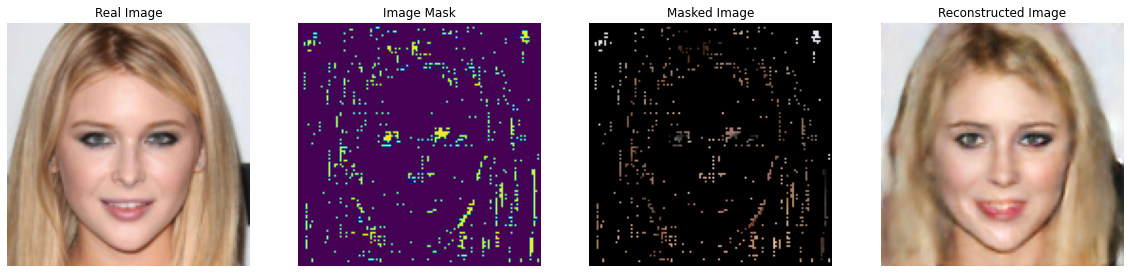

In [8]:
from matplotlib import pyplot as plt
  
fig = plt.figure(figsize=(20, 12))  
rows = 1
columns = 4

fig.add_subplot(rows, columns, 1)
plt.imshow(data)
plt.axis('off')
plt.title("Real Image")
  

fig.add_subplot(rows, columns, 2)
plt.imshow(image_masks)
plt.axis('off')
plt.title("Image Mask")
  

fig.add_subplot(rows, columns, 3)
plt.imshow(masked_imgs)
plt.axis('off')
plt.title("Masked Image")
  
fig.add_subplot(rows, columns, 4)
plt.imshow(fake_images)
plt.axis('off')
plt.title("Reconstructed Image")

print("Chosen pixels: "+str(chosen_pixels))

### 4.7. Relevance to Fine-grained data distributions:

From the examples shown in the [A WASSERSTEIN GAN FOR JOINT LEARNING
OF INPAINTING AND ITS SPATIAL OPTIMISATION
](https://arxiv.org/pdf/2202.05623.pdf), we can infer that the Joint Training methodology does a good job with reconstruction of general distributions. But in fine-grained datasets like CELEB A HQ facial identity dataset, **it is important that the reconstruction belongs to the distribution of the real image**. To put it simply, the faces in the real and reconstructed image must belong to the same person. **But this might not be the case** as shown in the image below. Though there are some similarities, they look like different people. <br>
![](.\\Test_images\\real1.png)
![](.\\Test_images\\real2.png)

One possible solution to this problem would be to use **conditional GANs** that additionally take the modality information and tailor the GAN performance accordingly. But this **introduces the additional task of identifying the modality** of the real image.

### 4.8. Out-of-distribution Performance

There are two ways to compress images using Deep Neural Networks.
1. Autoencoder-Decoder networks with bottleneck embeddings as the compressed form,
2. Sparse pixel selection with mask/selected pixels as the compressed form.

My **preliminary views** on the application of both these methods for image compression were as follows.
* For the Autoencoder-Decoder networks, the task at hand is to **learn the latent distribution of given images**. Autoencoder networks achieve a better compressions rate of both for a fixed distribution of decent size. But to fit a very large distribution we need to scale the size of the embedding accordingly. Otherwise, the performance suffers due to underfitting.
* Sparse pixel selection methods don't try to learn the image distribution and instead **learn the task of choosing relevant pixels along the high frequent regions(edges)**. The task for the inpainting generator network would then be to **colour missing pixels according to the boundary pixels**. This task would be much more scalable as it is **independent of input distributions**.

The way I visualized the above scenario is:<br>
**Goal:** paint a picture.<br>
> **Autoencoder-Decoder:** Given a description of the picture(some sort of embedding), draw it from memory.<br>
> **Sparse pixel selection:** Given a colouring book with bounded regions and colours at each boundary, fill the regions.<br>

The examples in the paper show how relevant pixels are chosen on the edges and inpainting takes care of the colour filling. I wanted to see if my assumptions about sparse pixel selection methods are correct and that the inpainting generator network learns the colouring task and does not memorize the input distribution in any way. To this extent, I used the model learned on CELEB A HQ facial dataset and applied it to a few images from **PARIS Street view dataset(no faces in them)**. The results are as follows:

![](.\\Test_images\\Paris_1.png)
![](.\\Test_images\\Paris_2.png)
![](.\\Test_images\\Paris_3.png)

If we look closely, we faintly notice faces in the reconstructed images. That means that the **inpainting generator network is learning the input image distribution rather than just colouring**. This raises questions about the scalability of Sparse pixel selection methods.

## Conclusions

In the spatial optimization problem, the mask generation and inpainting processes are highly interdependent. The success of each one of them depends on how robust the other unit functions. [[P22]](#Bibliography) recommends using Wasserstein GANs, which were proven to be successful at inpainting. Further, streamlining the binarization process to fit into backpropagation-based learning facilitated consistency between the train and test scenarios. The good PSNR and SSIM values, shown in [Section 4.5](#4.5.-RESULTS:-METRICS), prove the method's success. The reconstructed images look decently natural, with only around 6% of the total pixels saved.

Though quantitative performance looks good, some issues were observed too. For example, some face reconstructions weren't consistent with the person in the original image. This casts a doubt on the applicability of the proposed method to fine-grained data. The use of more sophisticated losses like multi-scale SSIM that capture fine structural information could yield better results when compared to an L1-based reconstruction loss. Further, the learned models don't work at all for out-of-distribution data. There is the additional restriction that a learned model only works for a certain mask density and image resolution. This inhibits the general applicability of the models towards applications like image compression. One improvement would be to design a framework where the confidence value of a pixel corresponds to its conditional importance with respect to the other pixels. Users can then select pixels incrementally until a satisfactory reconstruction is reached.

## Bibliography

__[[ACB17]](https://arxiv.org/abs/1701.07875)__ M. Arjovsky, S. Chintala, and L. Bottou: Wasserstein generative adversarial networks. In: International conference on machine learning, pp. 214-223. PMLR, 2017.

__[[APW22]](https://link.springer.com/chapter/10.1007/978-3-031-04881-4_42)__ T. Alt, P. Peter, J. Weickert: Learning Sparse Masks for Diffusion-Based Image Inpainting. In: Pinho, A.J., Georgieva, P., Teixeira, L.F., Sánchez, J.A. (eds) Pattern Recognition and Image Analysis. IbPRIA 2022. Lecture Notes in Computer Science, vol 13256. Springer, Cham.

__[[BLS16]](https://arxiv.org/abs/1607.05006)__ J. Ballé, V. Laparra, and E. P. Simoncelli: End-to-end optimization of nonlinear transform codes for perceptual quality. In: 2016 Picture Coding Symposium (PCS), pp. 1-5. IEEE, 2016.

__[[DCPC+20]](https://ieeexplore.ieee.org/document/8930037)__ Q. Dai, H. Chopp, E. Pouyet, O. Cossairt, M. Walton and A. K. Katsaggelos: Adaptive Image Sampling Using Deep Learning and Its Application on X-Ray Fluorescence Image Reconstruction. In: IEEE Transactions on Multimedia, vol. 22, no. 10, pp. 2564-2578, Oct. 2020, doi: 10.1109/TMM.2019.2958760.

__[[GAAD+17]](https://arxiv.org/abs/1704.00028)__ I. Gulrajani, F. Ahmed, M. Arjovsky, V. Dumoulin, and A. C. Courville: Improved training of wasserstein gans. In: Advances in neural information processing systems 30 (2017).

__[[MHWT+12]](https://link.springer.com/chapter/10.1007/978-3-642-24785-9_3)__ M. Mainberger, S. Hoffmann, J. Weickert, C. H. Tang, D. Johannsen, F. Neumann & B. Doerr : Optimising Spatial and Tonal Data for Homogeneous Diffusion Inpainting. In: Bruckstein, A.M., ter Haar Romeny, B.M., Bronstein, A.M., Bronstein, M.M. (eds) Scale Space and Variational Methods in Computer Vision. SSVM 2011. Lecture Notes in Computer Science, vol 6667. Springer, Berlin, Heidelberg. , 2012

__[[MKKY18]](https://arxiv.org/abs/1802.05957)__ T. Miyato, T. Kataoka, M. Koyama, and Y. Yoshida: Spectral normalization for generative adversarial networks. arXiv preprint arXiv:1802.05957 (2018).

__[[P22]](https://arxiv.org/abs/2202.05623)__ P. Peter: A Wasserstein GAN for Joint Learning of Inpainting and its Spatial Optimisation. ArXiv preprint arXiv:2202.05623, 2022

__[[TOHV+15]](https://arxiv.org/abs/1511.06085)__ G. Toderici, S. M. O'Malley, S. J. Hwang, D. Vincent, D. Minnen, S. Baluja, M. Covell, and R. Sukthankar: Variable rate image compression with recurrent neural networks. arXiv preprint arXiv:1511.06085 (2015).

__[[TSCH17]](https://arxiv.org/abs/1703.00395)__ L. Theis, W. Shi, A. Cunningham, and F. Huszár: Lossy image compression with compressive autoencoders. arXiv preprint arXiv:1703.00395, 2017

__[[VHF21]](https://link.springer.com/chapter/10.1007/978-3-030-86340-1_46)__ D. Vašata, T. Halama, M. Friedjungová: Image Inpainting Using Wasserstein Generative Adversarial Imputation Network. In: Farkaš, I., Masulli, P., Otte, S., Wermter, S. (eds) Artificial Neural Networks and Machine Learning – ICANN 2021. ICANN 2021. Lecture Notes in Computer Science(), vol 12892. Springer, Cham.